# load and make transformations to ensure linear relationships between dependent variables and to de-confound population dependent variables

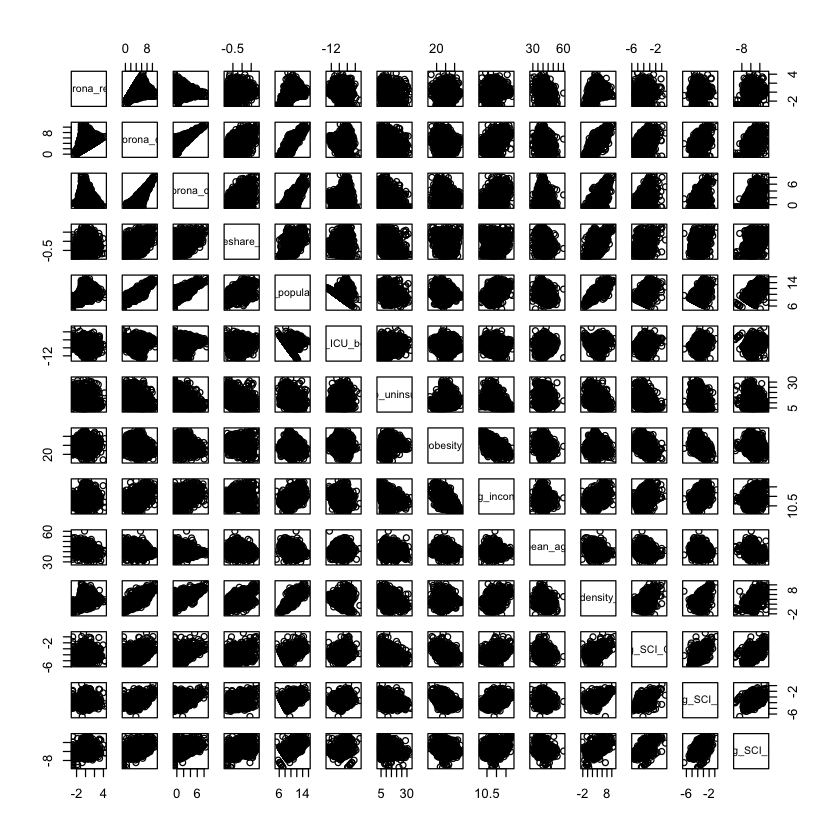

In [18]:
df <- read.csv('county_level_df')#, sep=',', header = TRUE)

df$log_population <- log(df$population)
df$log_income <- log(df$income)
df$log_corona_cases <- log(df$corona_cases + 0.5)
df$log_corona_deaths <- log(df$corona_deaths + 0.5)
df$log_ICU_beds <- log((df$ICU_beds + 0.5)/df$population)
df$log_density_pop <- log(df$density_pop)
df$log_density_house <- log(df$density_house)
df$log_SCI_CN <- log((df$SCI_CN + 0.1)/df$population)
df$log_SCI_IT <- log((df$SCI_IT + 0.1)/df$population)
df$log_SCI_IR <- log((df$SCI_IR + 0.1)/df$population)

#variation in confimred case data, not explained by the death data
df$log_corona_residual <- lm(log_corona_cases ~ log_corona_deaths,data=df)$residual


#plot pairwise correlations between operative variables
z <- df[c('log_corona_residual','log_corona_cases','log_corona_deaths','voteshare_diff', 
          'log_population','log_ICU_beds', 'prop_uninsured', 'obesity',
          'log_income','mean_age','log_density_pop',
          'log_SCI_CN', 'log_SCI_IT','log_SCI_IR')]

pairs(z)

In [20]:
dim(df)

[1] 3104 6246

# transform the network data, so that the adj matrices are symmetrical 

In [22]:
average_upper_lower_triangles <- function(m1) {
    
    m2 <- matrix(0, ncol = ncol(m1), nrow = nrow(m1))
    tri.av <- rowMeans(cbind(m1[upper.tri(m1, diag = FALSE)], 
                                    m1[lower.tri(m1, diag = FALSE)]))

    m2[lower.tri(m2)] <- tri.av
    #m2[upper.tri(m2)] <- tri.av  
    
    print(dim(m2))

    #m2[is.na(m2)] <- 0
    m2 <- t(m2) + m2
    
    return(m2)
}

adj_matrix = 'net_'

Dmat <- as.matrix(df[,grepl( adj_matrix , names( df ) )])
Dmat[Dmat == 0] = 0.1
Dmat <- average_upper_lower_triangles(Dmat) # average in and out the network links between each county pair

Dmat <- 1/Dmat # convert from similarity to distance network (also reduces skew)
diag(Dmat) <- 0


Dmat_net <- Dmat/1000


adj_matrix = 'geo_'

Dmat <- as.matrix(df[,grepl( adj_matrix , names( df ) )])
Dmat <- average_upper_lower_triangles(Dmat) # average in and out the network links between each county pair

max <- max(Dmat,na.rm = TRUE)
Dmat_geo <- Dmat#(max - Dmat)/max

#check if network matrices are symetrical
isSymmetric(Dmat_net)
isSymmetric(Dmat_geo)

[1] 3104 3104
[1] 3104 3104


[1] TRUE

[1] TRUE

# declare functions for network Poisson regression

In [24]:
library("tnam")
library('lmtest')
library('rsq')
library('sandwich')
library('prodlim')
library("texreg")

prepare_target <- function(target){
    y <- df[,target]
    y <- as.data.frame(y)
    rownames(y) <- letters  
    return(y)
}

prepare_covariates <- function(dep){
    x <- df[,dep]
    names(x) <- letters
    #x <- list(t1 = x)
    x <- covariate(x, coefname = dep)
    return(x)
}

prepare_networks <- function(y,Dmat){
    row.names(Dmat) <- letters
    #Dmat <- list(t1 = Dmat)
    Dmat <- netlag(y, Dmat)
    return(Dmat)
}

dispersion <- function(M) {
    E2 <- resid(M, type = "pearson")
    N  <- length(M$residuals)
    p  <- length(coef(M))   
    
    return(sum(E2^2) / (N - p))  
}

tnam_get_fitted_values <- function(model,dep,target){

    #model <- model_undereport
    df_match <- df[,c(target,dep)]

    df_model <- model$model
    df_model <- df_model[,-grep('netlag.',colnames(df_model))]

    fitted_values <- model$fitted.values[row.match(df_match, df_model, nomatch = NA)]

    return(fitted_values)
}


letters<-as.character(df$FIPS)

dep = c('voteshare_diff', 'log_population','log_ICU_beds', 'prop_uninsured','log_income', 'mean_age', 'obesity','log_density_pop',
          'log_SCI_CN', 'log_SCI_IT','log_SCI_IR')

networks = c('Dmat_net','Dmat_geo')

#create covariates
cv = list()
for (i in seq(length(dep))) {
    #print(prepare_covariates(dep[i]))
    cv[[i]] <- prepare_covariates(dep[i])    
}

names(cv) <- dep

Loading required package: xergm.common

Loading required package: ergm

Loading required package: network

network: Classes for Relational Data
Version 1.16.0 created on 2019-11-30.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.



ergm: version 3.10.4, created on 2019-06-10
Copyright (c) 2019, Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Carter T. Butts, University of California -- Irvine
                    Steven M. Goodreau, University of Washington
                    Pavel N. Krivitsky, University of Wollongong
 

# model COVID-19 deaths with Poisson model (no network data)

In [29]:
model_deaths_nonet <- glm(corona_deaths ~ voteshare_diff + log_population + log_ICU_beds + prop_uninsured + log_income + mean_age +
    obesity + log_density_pop + log_SCI_CN + log_SCI_IT + log_SCI_IR  ,data=df, family = 'poisson')

coeftest(model_deaths_nonet, vcov = sandwich)


z test of coefficients:

                  Estimate Std. Error z value  Pr(>|z|)    
(Intercept)     -22.278691   2.885179 -7.7218 1.147e-14 ***
voteshare_diff    0.827485   0.190775  4.3375 1.441e-05 ***
log_population    1.065704   0.053236 20.0183 < 2.2e-16 ***
log_ICU_beds     -0.138862   0.061638 -2.2529 0.0242682 *  
prop_uninsured   -0.053122   0.012455 -4.2650 1.999e-05 ***
log_income        0.517845   0.205044  2.5255 0.0115525 *  
mean_age          0.051666   0.019538  2.6444 0.0081847 ** 
obesity           0.052631   0.013670  3.8501 0.0001181 ***
log_density_pop   0.385528   0.050632  7.6144 2.650e-14 ***
log_SCI_CN       -0.438545   0.160727 -2.7285 0.0063621 ** 
log_SCI_IT        0.746986   0.124105  6.0190 1.755e-09 ***
log_SCI_IR       -0.338066   0.086773 -3.8960 9.779e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Poisson network model of COVID-19 deaths

In [26]:
# dependent variable y
target <- 'corona_deaths'
y <- prepare_target(target)

#networks
Dmat_net_form <- prepare_networks(y,Dmat_net)
Dmat_geo_form <- prepare_networks(y,Dmat_geo)

model_deaths <- tnam(
    y ~ cv$voteshare_diff + cv$log_population + cv$log_ICU_beds + cv$prop_uninsured + cv$log_income 
    + cv$mean_age + cv$obesity + cv$log_density_pop + cv$log_SCI_CN + cv$log_SCI_IT + cv$log_SCI_IR 
    + Dmat_geo_form + Dmat_net_form, 
     family = 'poisson') 


print(c('dispersion: ',dispersion(model_deaths)))
#coeftest(model_deaths, vcov = sandwich)

#coeftest(model_undereport, vcov = sandwich)

[1] "dispersion: "     "28.3603576060154"


In [28]:
coeftest(model_deaths, vcov = sandwich)


z test of coefficients:

                             Estimate  Std. Error z value  Pr(>|z|)    
(Intercept)               -7.7512e-01  3.8113e+00 -0.2034 0.8388437    
covariate.voteshare_diff   1.0285e+00  1.6799e-01  6.1227 9.201e-10 ***
covariate.log_population   9.9999e-01  4.8671e-02 20.5457 < 2.2e-16 ***
covariate.log_ICU_beds     1.0772e-01  4.0781e-02  2.6415 0.0082528 ** 
covariate.prop_uninsured  -4.1798e-02  1.1171e-02 -3.7418 0.0001827 ***
covariate.log_income       1.0776e+00  2.1922e-01  4.9157 8.845e-07 ***
covariate.mean_age         3.9771e-02  1.3759e-02  2.8905 0.0038468 ** 
covariate.obesity          6.5197e-02  1.3338e-02  4.8881 1.018e-06 ***
covariate.log_density_pop  1.3881e-01  4.6004e-02  3.0174 0.0025492 ** 
covariate.log_SCI_CN      -4.1907e-01  1.4258e-01 -2.9391 0.0032915 ** 
covariate.log_SCI_IT       6.0977e-01  1.1101e-01  5.4931 3.949e-08 ***
covariate.log_SCI_IR      -2.9781e-01  7.4507e-02 -3.9970 6.414e-05 ***
netlag.pathdist1.x         3.2297e-05 

# add predicted number of deaths from network Poisson regression to dataframe. Then add estimates for underreporting, based on variance in confirmed cases not explained by death count

In [30]:
target <- 'corona_deaths'
df$fitted_deaths <- tnam_get_fitted_values(model_deaths,dep,target)
df$log_fitted_deaths <- log(df$fitted_deaths)


#estimate underreporting
fit<-lm(log_corona_cases ~ log_corona_deaths,data=df,family='gaussian')
df$corona_underreport <- fit$residuals - min(fit$residuals) + 2
df$log_corona_underreport <- log(df$corona_underreport)

Warning message:
“In lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...) :
 extra argument ‘family’ will be disregarded”


# Run Gaussian regression (no networks) to predict underreporting

In [31]:
model_undereport_nonet <- glm(log_corona_underreport ~ voteshare_diff + log_population + 
                              + log_ICU_beds + prop_uninsured + log_income + mean_age +
    obesity + log_density_pop + log_SCI_CN + log_SCI_IT + log_SCI_IR ,data=df,family='gaussian')


#get starting parameter values for tnam function
CC<-coef(model_undereport_nonet)
CC$kappa1 <- 0
CC$kappa2 <- 0
etastart <- model_undereport_nonet$y

Warning message in CC$kappa1 <- 0:
“Coercing LHS to a list”


# Run network regression to predict underreporting 

In [32]:
# dependent variable y
#target <- 'log_corona_underreport'
#y <- prepare_target(target)

#networks
#Dmat_net_form <- prepare_networks(y,Dmat_net)
#Dmat_geo_form <- prepare_networks(y,Dmat_geo)

#model_undereport <- tnam(
#    y ~ cv$voteshare_diff + cv$log_population + cv$log_ICU_beds +
#    cv$prop_uninsured + cv$log_income + cv$mean_age +
#    cv$obesity + cv$log_density_pop + cv$log_SCI_CN + cv$log_SCI_IT + cv$log_SCI_IR 
#    + Dmat_geo_form + Dmat_net_form, 
#    start=CC, etastart=etastart, family = 'gaussian')

library('sna')

y<-df$log_corona_underreport
#y<-df$pca_cases
x<-as.matrix(df[,c('voteshare_diff', 
          'log_population', 'log_ICU_beds','prop_uninsured', 
          'log_income','mean_age','obesity','log_density_pop',
          'log_SCI_CN', 'log_SCI_IT','log_SCI_IR')])

#x<-as.matrix(df[,c('log_corona_deaths','voteshare_diff', 
#          'log_population', 'prop_uninsured', 'mean_age')])

model_undereport <- lnam(y, x , W2=list(Dmat_geo,Dmat_net))


Loading required package: statnet.common


Attaching package: ‘statnet.common’


The following object is masked from ‘package:base’:

    order


sna: Tools for Social Network Analysis
Version 2.5 created on 2019-12-09.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
 For citation information, type citation("sna").
 Type help(package="sna") to get started.



Attaching package: ‘sna’


The following objects are masked from ‘package:prodlim’:

    neighborhood, redist


Loading required namespace: numDeriv



ERROR: Error in UseMethod("vcov"): no applicable method for 'vcov' applied to an object of class "lnam"


# save models and updated dataframe with predicted COVID-19 deaths and underreporting for plotting geographic maps

In [34]:
save(model_undereport_nonet, file="model_undereport_nonet.rda")
save(model_undereport, file="model_undereport.rda")

save(model_deaths_nonet, file="model_deaths_nonet.rda")
save(model_deaths, file="model_deaths.rda")

write.table(df,'county_level_df_with_fitted_values',sep=',')